In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
sbn.set()
from cvxopt import matrix, solvers 

data = np.loadtxt('iris-pca.txt')
X = data[:,:2]
y = np.array([-1 if x == 0 else 1 for x in data[:,2]])     

# Kernels

In [30]:
def rbf_kernel(x, y, gamma=0.633):
    return np.exp(-gamma * np.linalg.norm(x - y)**2)

def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel(x, y, p=3):
    return (1 + np.dot(x, y)) ** p

def gaussian_kernel(x, y, sigma=5.0):
    return np.exp(-np.linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

# Support Vector Machine
<img src="support_vector_machine_nl_decision_function.jpg" align="left"  width="500"/>

In [16]:
class SupportVectorMachine():
    def __init__(self, kernel=linear_kernel, C=1, verbose=False):
        self.kernel = kernel
        self.C = float(C)
        self.verbose = verbose
        
    def fit(self, X, y):
        # Kernel Matrix / Gram Matrix - Apply kernel to each element of X
        K = np.array([self.kernel(X[i], X[j]) for i in range(len(X)) for j in range(len(X))]).reshape(len(X),len(X))
 
        # solve QP problem
        solvers.options['show_progress']=self.verbose
        solution = solvers.qp(
            matrix(np.outer(y,y) * K),  # P
            matrix(np.ones(len(X)) * -1),  # q
            matrix(np.vstack((np.diag(np.ones(len(X)) * -1), np.identity(len(X))))), # G
            matrix(np.hstack((np.zeros(len(X)), np.ones(len(X)) * self.C))), # H
            matrix([float(yi) for yi in y], (1,len(X))), # A
            matrix(0.0) # b
        )
        
        # alpha = lagrande multipliers
        self.alpha = np.ravel(solution['x'])
        
        self.b = np.median(self.alpha * y * K)
        
        # in linear case save only weight vector
        if self.kernel == linear_kernel: self.w = np.sum((self.alpha * y).reshape(-1,1) * X, axis=0)  
        #for !!non!! linear case save train data instead of w 
        else: (self.w, self.X, self.y) = (None, X, y)
            
    # get probability        
    def decision_function(self, x_pred):
        if self.w is not None:
            return np.dot(x_pred, self.w.T) + self.b
        else:
            return self.b + np.array([np.sum(np.array([ai * yi * self.kernel(x_pred_i, x_train_i) for ai, yi, x_train_i in zip(self.alpha, self.y, self.X)])) for x_pred_i in x_pred])
    # get class decision
    def predict(self, x_pred):
        return np.sign(self.decision_function(x_pred))

### Helper methods

In [12]:
# helper method to print the decision boundary with plt
def printDecisionBoundary(plotaxis, model): 
    ax = plotaxis
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    YMG, XMG = np.meshgrid(np.linspace(ylim[0], ylim[1], 50), np.linspace(xlim[0], xlim[1], 10))
    xy = np.vstack([XMG.ravel(),YMG.ravel()]).T
    decision = model.decision_function(xy)
    P = decision.reshape(XMG.shape)
    ax.contour(XMG, YMG, P, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', 'dotted'])
    
def svmTest(kernel):
    csv = SupportVectorMachine(kernel,C=10)
    csv.fit(X, y)

    ypred = csv.predict(X).flatten()
    f, (p1, p2) = plt.subplots(1,2, sharey=True, figsize = (15,5))

    p1.set_title("Decision boundary before classification")
    p1.scatter(X[:, 0], X[:, 1], c=data[:,2], cmap='autumn')
    printDecisionBoundary(p1, csv) 

    p2.set_title("Decision boundary after classification")
    p2.scatter(X[:, 0], X[:, 1], c=ypred, cmap='autumn')
    printDecisionBoundary(p2, csv) 

    plt.show()
    ycomp = np.array([0 if y == yc else 1 for (y,yc, i) in zip(y, ypred, range(0, len(y)))])
    print(f"Misclassified: {len(ycomp[ycomp==1])}")
    print(f"Correct classified: {len(ycomp[ycomp==0])}")
    print(f"Error rate: {len(ycomp[ycomp==1])/len(ycomp[ycomp==0])}")

# RBF Kernel Test

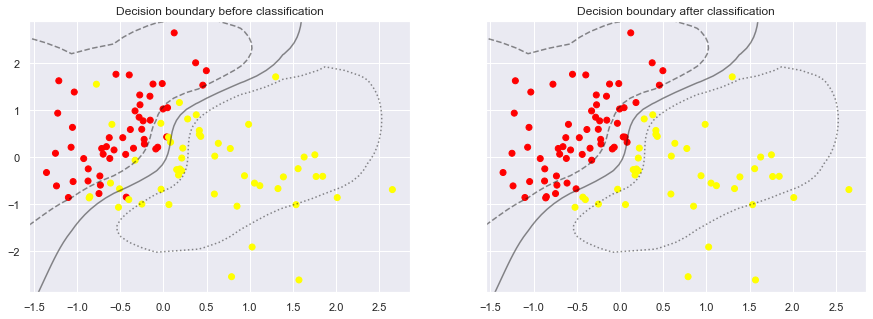

Misclassified: 12
Correct classified: 88
Error rate: 0.13636363636363635


In [14]:
svmTest(lambda p1,p2: rbf_kernel(p1, p2, 0.633))

# Linear Kernel Test

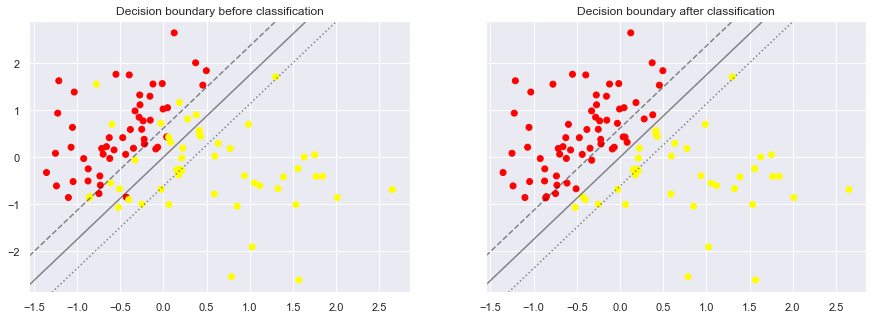

Misclassified: 14
Correct classified: 86
Error rate: 0.16279069767441862


In [18]:
svmTest(linear_kernel)

# Polynomial kernel test

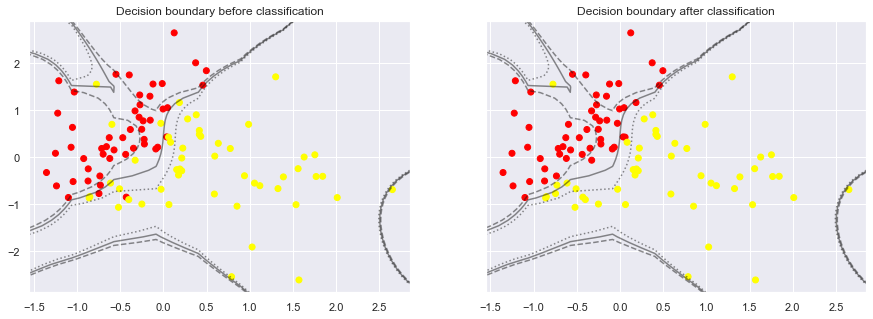

Misclassified: 8
Correct classified: 92
Error rate: 0.08695652173913043


In [24]:
svmTest(lambda p1,p2: polynomial_kernel(p1, p2, 4))

# Gaussian Kernel Test 
(Actually same as radial)

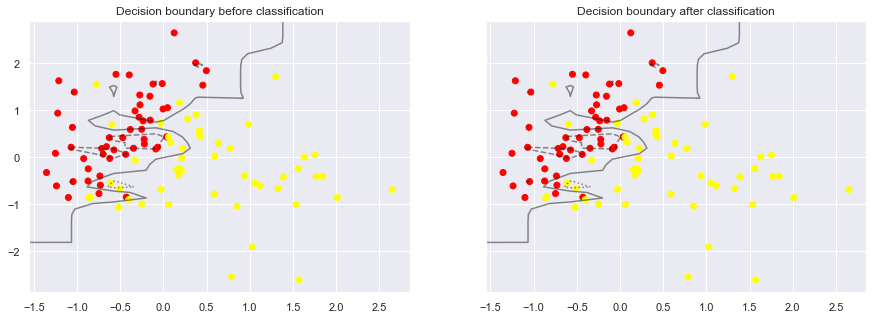

Misclassified: 0
Correct classified: 100
Error rate: 0.0


In [26]:
svmTest(lambda p1,p2: gaussian_kernel(p1, p2, 0.1))